In [ ]:
!pip install rasterio
!pip install rioxarray
!pip install geopandas
!pip install matplotlib
!pip install pandas
!pip install xarray
!pip install netCDF4
!pip install rioxarray
!pip install rasterio
!pip install geopandas
!pip install shapely
!pip install pyproj
!pip install fiona
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install gstools
!pip install libpysal
!pip install esda
!pip install scipy
!pip install pandas
!pip install numpy
!pip install tqdm
!pip install folium
!pip install contextily


  Cloning https://github.com/bsmurphy/PyKrige.git to /tmp/pip-req-build-ry_o2vun
  Running command git clone --filter=blob:none --quiet https://github.com/bsmurphy/PyKrige.git /tmp/pip-req-build-ry_o2vun
  Resolved https://github.com/bsmurphy/PyKrige.git to commit 5e896fb3398cc86acd735d170fb758a02528b70e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Import

In [ ]:
import xarray as xr
import pandas as pd
import rasterio
import os
import rioxarray
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import numpy as np
import pandas as pd
import xarray as xr
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from scipy.spatial import cKDTree
from skgstat import Variogram
import libpysal
from esda.moran import Moran

ModuleNotFoundError: No module named 'skgstat'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Init

Your data repository should look like **this** after downloading all input data:

![image-2.png](attachment:image-2.png)

In [ ]:
!python --version

Python 3.12.12


In [ ]:
main_data_folder = '/content/drive/MyDrive/data/'


# Administration geometries from GADM

[GADM](https://gadm.org/) provides maps and spatial data for all countries and their sub-divisions. Here is a light version limited to European countries.

In [ ]:
gadm_filepath = main_data_folder + "gadm_410_europe.gpkg"

## Parametrize

In [ ]:
country_code = "DEU" # Germany
cityname = "Berlin"

## Manipulate and vizualize

In [ ]:
gadm_gdf = gpd.read_file(gadm_filepath)

print(f"Number of rows in GADM: {len(gadm_gdf)}")
gadm_gdf.head()

Number of rows in GADM: 106252


,UID,GID_0,NAME_0,GID_1,NAME_1,ENGTYPE_1,GID_2,NAME_2,ENGTYPE_2,GID_3,...,ENGTYPE_3,GID_4,NAME_4,ENGTYPE_4,GID_5,NAME_5,ENGTYPE_5,COUNTRY,CONTINENT,geometry
0,333,ALA,Åland,ALA.1_2,Archipelago,Sub-Region,ALA.1.1_2,Brändö,Municipality,,...,,,,,,,,Åland,Europe,"MULTIPOLYGON (((20.98333 60.64167, 20.98125 60..."
1,334,ALA,Åland,ALA.1_2,Archipelago,Sub-Region,ALA.1.2_2,Föglö,Municipality,,...,,,,,,,,Åland,Europe,"MULTIPOLYGON (((20.60028 59.81311, 20.60027 59..."
2,335,ALA,Åland,ALA.1_2,Archipelago,Sub-Region,ALA.1.3_2,Kökar,Municipality,,...,,,,,,,,Åland,Europe,"MULTIPOLYGON (((20.83333 60.03333, 20.83301 60..."
3,336,ALA,Åland,ALA.1_2,Archipelago,Sub-Region,ALA.1.4_2,Kumlinge,Municipality,,...,,,,,,,,Åland,Europe,"MULTIPOLYGON (((20.76042 60.46667, 20.75833 60..."
4,337,ALA,Åland,ALA.1_2,Archipelago,Sub-Region,ALA.1.1_2,Sottunga,Municipality,,...,,,,,,,,Åland,Europe,"MULTIPOLYGON (((20.56875 60.18333, 20.56667 60..."


In [ ]:
filtered_gadm_gdf = gadm_gdf[(gadm_gdf.GID_0 == country_code) & (gadm_gdf.NAME_2 == cityname)]

print(f"Number of rows in GADM after filtering: {len(filtered_gadm_gdf)}")
filtered_gadm_gdf.head()

Number of rows in GADM after filtering: 1


,UID,GID_0,NAME_0,GID_1,NAME_1,ENGTYPE_1,GID_2,NAME_2,ENGTYPE_2,GID_3,...,ENGTYPE_3,GID_4,NAME_4,ENGTYPE_4,GID_5,NAME_5,ENGTYPE_5,COUNTRY,CONTINENT,geometry
55223,95755,DEU,Germany,DEU.3_1,Berlin,State,DEU.3.1_1,Berlin,District,DEU.3.1.1_1,...,Municipality,DEU.3.1.1.1_1,Berlin,Town,,,,Germany,Europe,"MULTIPOLYGON (((13.50022 52.61379, 13.49855 52..."


In [ ]:
one_city_gdf = filtered_gadm_gdf.dissolve()

one_city_gdf.head()

,geometry,UID,GID_0,NAME_0,GID_1,NAME_1,ENGTYPE_1,GID_2,NAME_2,ENGTYPE_2,...,NAME_3,ENGTYPE_3,GID_4,NAME_4,ENGTYPE_4,GID_5,NAME_5,ENGTYPE_5,COUNTRY,CONTINENT
0,"POLYGON ((13.50022 52.61379, 13.49855 52.61068...",95755,DEU,Germany,DEU.3_1,Berlin,State,DEU.3.1_1,Berlin,District,...,Berlin,Municipality,DEU.3.1.1.1_1,Berlin,Town,,,,Germany,Europe


<Axes: >

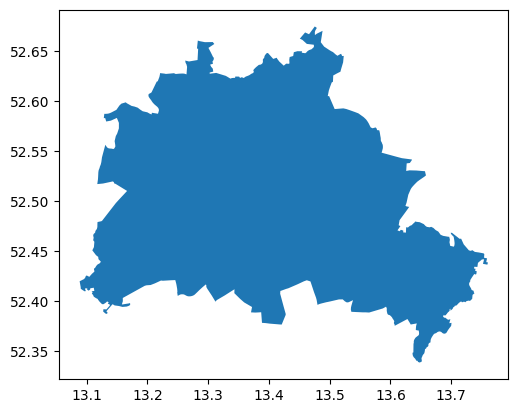

In [ ]:
one_city_gdf.plot()

Warning! Depending on the country you're studying, the administrative level of the city might be different.

For example, "Berlin" in Germany requires the `gadm_gdf.NAME_2 == cityname` condition (ie. admin level 2), however "Lille" in France requires the `gadm_gdf.NAME_5 == cityname` condition (ie. admin level 5).

It can even vary within a country if a city is divided in boroughs (ex: "Paris" in France requires the `gadm_gdf.NAME_2 == cityname` condition (ie. admin level 2)).

# ERA5-Land Meteorological data (frequency = daily)

ERA5-Land is a reanalysis dataset providing a consistent view of the evolution of land variables over several decades at an enhanced resolution compared to ERA5.

The data, processed on a daily temporal resolution, originally stems from a public hourly dataset: [ERA5-Land hourly data from 1950 to present](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview) on the [Climate Data Store](https://cds.climate.copernicus.eu/).

The available land variables are:
- Daily maximum of hourly [2 metre temperature](https://apps.ecmwf.int/codes/grib/param-db/167) in Kelvin,
- Daily mean of hourly [total precipitation](https://apps.ecmwf.int/codes/grib/param-db/228) in meters,
- Daily mean of hourly [10 metre U wind component](https://apps.ecmwf.int/codes/grib/param-db/165) in meters per second,
- Daily mean of hourly [10 metre V wind component](https://apps.ecmwf.int/codes/grib/param-db/166) in meters per second.

In [ ]:
era5_data_folder = main_data_folder + "derived-era5-land-daily-statistics/"

variable2statistic = {
    "2m_temperature": "daily_maximum",
    "total_precipitation": "daily_mean",
    "10m_u_component_of_wind": "daily_mean",
    "10m_v_component_of_wind": "daily_mean",
}

variable2datavar = {
    "2m_temperature": "t2m",
    "total_precipitation": "tp",
    "10m_u_component_of_wind": "u10",
    "10m_v_component_of_wind": "v10",
}

## Parametrize

In [ ]:
variable = "10m_u_component_of_wind"
year = 2020

In [ ]:
statistic = variable2statistic[variable]
datavar = variable2datavar[variable]

## Manipulate and vizualize

Please open the [xarray User Guide](https://docs.xarray.dev/en/stable/user-guide/index.html) to see how to manipulate the data (especially in the "Core operations" chapter).

Here are a few examples of operations:

### One dataset

In [ ]:
filepath = f"{era5_data_folder}{year}_{variable}_{statistic}.nc"

In [ ]:
ds = xr.open_dataset(filepath)
ds

<xarray.Dataset> Size: 338MB
Dimensions:     (valid_time: 366, latitude: 350, longitude: 660)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 3kB 2020-01-01 ... 2020-12-31
  * latitude    (latitude) float64 3kB 69.9 69.8 69.7 69.6 ... 35.2 35.1 35.0
  * longitude   (longitude) float64 5kB -25.0 -24.9 -24.8 ... 40.7 40.8 40.9
    number      int64 8B ...
Data variables:
    u10         (valid_time, latitude, longitude) float32 338MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-04T23:34 GRIB to CDM+CF via cfgrib-0.9.1...

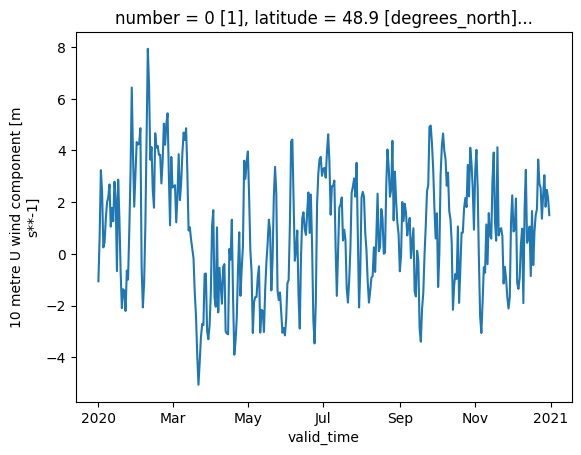

In [ ]:
lat, lon = 48.8566, 2.3522

ds[datavar].sel(latitude=lat, longitude=lon, method="nearest").plot()

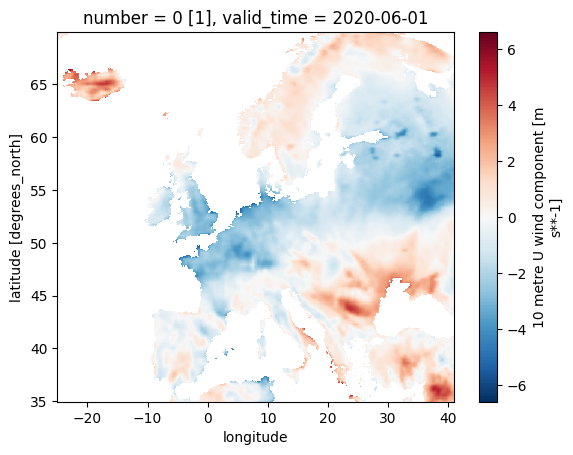

In [ ]:
day = pd.to_datetime(f"{year}-06-01")

ds[datavar].sel(valid_time=day).plot()

### Multiple datasets

In [ ]:
filepaths = glob(f"{era5_data_folder}*_{variable}_{statistic}.nc")

In [ ]:
ds = xr.open_mfdataset(filepaths, combine="by_coords")
ds

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 2101, latitude: 350, longitude: 660)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 17kB 2020-01-01 ... 2025-10-01
  * latitude    (latitude) float64 3kB 69.9 69.8 69.7 69.6 ... 35.2 35.1 35.0
  * longitude   (longitude) float64 5kB -25.0 -24.9 -24.8 ... 40.7 40.8 40.9
    number      int64 8B 0
Data variables:
    u10         (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(23, 22, 42), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-04T23:34 GRIB to CDM+CF via cfgrib-0.9.1...

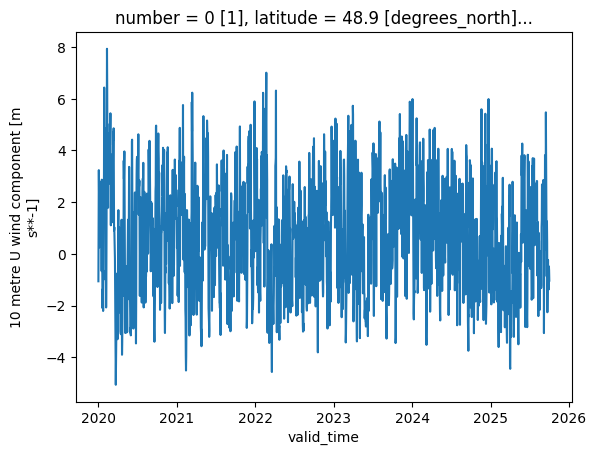

In [ ]:
ds[datavar].sel(latitude=lat, longitude=lon, method="nearest").plot()

# Normalized Difference Vegetation Index from Sentinel-2 (frequency = every 3 months)

The Normalized difference vegetation index (known as NDVI) is a simple, but effective index for quantifying green vegetation. Its values range from -1 to 1. More details on [sentinelhub](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndvi/).

In [ ]:
ndvi_data_folder = main_data_folder + "sentinel2_ndvi/"

def quarter2timeperiod(year, quarter):
    if quarter == 1:
        return f"{year-1}-12-01_{year}-03-01"
    elif quarter == 2:
        return f"{year}-03-01_{year}-06-01"
    elif quarter == 3:
        return f"{year}-06-01_{year}-09-01"
    elif quarter == 4:
        return f"{year}-09-01_{year}-12-01"
    else:
        raise ValueError("quarter must be in 1, 2, 3, 4")

## Parametrize

In [ ]:
available_years = [2020, 2021, 2022, 2023]
available_quarters = [1, 2, 3, 4]

In [ ]:
year = 2020
quarter = 4

In [ ]:
timeperiod = quarter2timeperiod(year, quarter)

filepath  = f"{ndvi_data_folder}ndvi_{timeperiod}.tif"

## Manipulate and vizualize

In [ ]:
def convert_ndvi_to_real_scale(ndvi_img, out_meta):
    # The NDVI is stored in int8 format on a 0/254 scale, and nodata is 255.
    # This function converts it to a float format on a -1/1 scale, and replace nodata with np.nan.
    ndvi_img = ndvi_img.astype(float)
    ndvi_img[ndvi_img == out_meta["nodata"]] = np.nan
    ndvi_img = ndvi_img / 254 * 2 - 1
    return ndvi_img

def get_out_image_and_metadata(filepath, one_city_gdf):
    with rasterio.open(filepath) as src:
        one_city_gdf_in_good_crs = one_city_gdf.to_crs(src.crs)
        city_geometry = [one_city_gdf_in_good_crs.geometry.iloc[0]]
        out_image, out_transform = mask(src, city_geometry, crop=True)
        out_meta = src.meta

        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

        real_out_image = convert_ndvi_to_real_scale(out_image, out_meta)

    return real_out_image, out_meta

In [ ]:
real_out_image, out_meta = get_out_image_and_metadata(filepath, one_city_gdf)

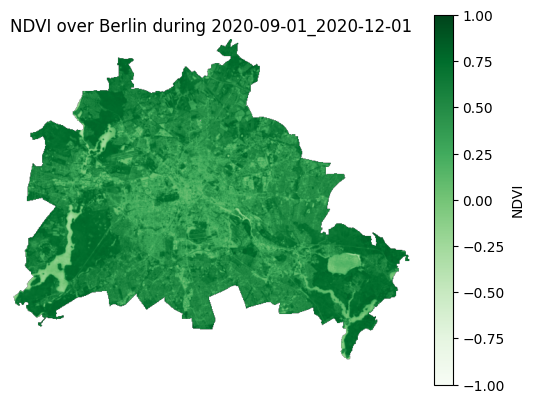

In [ ]:
plt.figure()
plt.imshow(real_out_image[0], cmap='Greens', vmin=-1, vmax=1)
plt.colorbar(label="NDVI")
plt.title(f"NDVI over {cityname} during {timeperiod}")
plt.axis('off')
plt.show()

In [ ]:
mean_ndvi = np.nanmean(real_out_image[0])
print(f"Mean NDVI over {cityname} during {timeperiod}: {mean_ndvi:.3f}")

Mean NDVI over Berlin during 2020-09-01_2020-12-01: 0.509


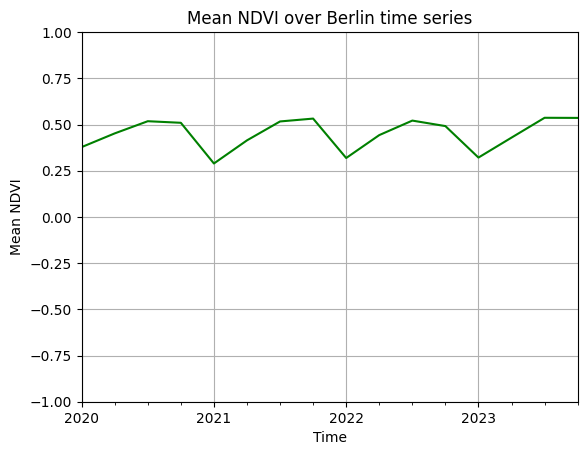

In [ ]:
mean_ndvi_time_series = pd.Series(dtype=float)
for year in available_years:
    for quarter in available_quarters:
        timeperiod = quarter2timeperiod(year, quarter)
        filepath  = f"{ndvi_data_folder}ndvi_{timeperiod}.tif"
        date = pd.to_datetime(timeperiod.split("_")[1])
        current_real_out_image, _ = get_out_image_and_metadata(filepath, one_city_gdf)
        current_mean_ndvi = np.nanmean(current_real_out_image[0])
        mean_ndvi_time_series.loc[date] = current_mean_ndvi

mean_ndvi_time_series = mean_ndvi_time_series.sort_index()

plt.figure()
mean_ndvi_time_series.plot(color='green')
plt.title(f"Mean NDVI over {cityname} time series")
plt.ylabel("Mean NDVI")
plt.xlabel("Time")
plt.ylim(-1, 1)
plt.grid()
plt.show()

## Reproject ERA5-Land features on the NDVI grid

In [ ]:
da = ds[datavar].sel(valid_time=day)
da

<xarray.DataArray 'u10' (latitude: 350, longitude: 660)> Size: 924kB
dask.array<getitem, shape=(350, 660), dtype=float32, chunksize=(22, 42), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float64 3kB 69.9 69.8 69.7 69.6 ... 35.2 35.1 35.0
  * longitude   (longitude) float64 5kB -25.0 -24.9 -24.8 ... 40.7 40.8 40.9
    number      int64 8B 0
    valid_time  datetime64[ns] 8B 2020-06-01
Attributes: (12/32)
    GRIB_paramId:                             165
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      6483600
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               m s**-1
    long_name:                                10 metre U wind component
    units:                                    m s**-1
    standard_name:                            unknown
    GRIB_surface:                             0.0

In [ ]:
origin_transform = from_bounds(
    ds.longitude.min().item(),
    ds.latitude.min().item(),
    ds.longitude.max().item(),
    ds.latitude.max().item(),
    len(ds.longitude),
    len(ds.latitude)
)
origin_crs = "EPSG:4326"

target_transform = out_meta["transform"]
target_crs = out_meta["crs"]

In [ ]:
reprojected_da = da.rio.write_crs(origin_crs).rio.reproject(
    dst_crs=target_crs,
    shape=(out_meta["height"], out_meta["width"]),
    transform=target_transform,
)

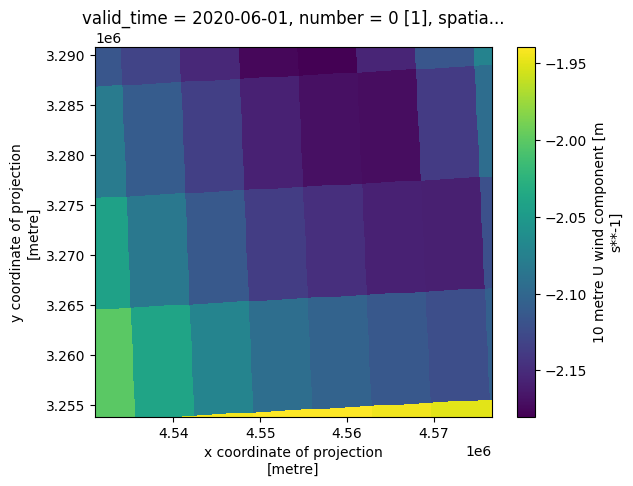

In [ ]:
reprojected_da.plot()

# Blended European Climate Assessment datasets

The data stems from the [European Climate Assessment & Dataset project website](https://www.ecad.eu/dailydata/predefinedseries.php).

The example dataset is "Daily maximum temperature TX" (ie. `ECA_blend_tx`).

In [ ]:
eca_tx_datafolder = main_data_folder + "ECA_blend_tx/"
stations_filepath = eca_tx_datafolder + "stations.txt"

## Filter weather stations

In [ ]:
def dms_to_decimal(dms_str):
    # This function converts a DMS (Degrees:Minutes:Seconds) string to decimal degrees.
    dms_str = dms_str.strip()

    sign = 1 if dms_str[0] == '+' else -1

    dms_str = dms_str[1:]

    parts = dms_str.split(':')
    degrees = float(parts[0])
    minutes = float(parts[1])
    seconds = float(parts[2])

    decimal = sign * (degrees + minutes/60 + seconds/3600)

    return decimal

In [ ]:
stations_df = pd.read_csv(
    stations_filepath,
    skiprows=17,
    skipinitialspace=True
)

stations_df['LAT_decimal'] = stations_df['LAT'].apply(dms_to_decimal)
stations_df['LON_decimal'] = stations_df['LON'].apply(dms_to_decimal)

stations_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df['LON_decimal'], stations_df['LAT_decimal']),
    crs="EPSG:4326" # (WGS84, adequate for lat/lon coordinates)
).drop(columns=['LAT', 'LON', 'LAT_decimal', 'LON_decimal'])

print(f"Number of registered stations: {len(stations_gdf)}")
stations_gdf.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/data/ECA_blend_tx/stations.txt'

In [ ]:
one_city_gdf.to_crs(stations_gdf.crs, inplace=True) # Use same CRS for spatial operations

stations_in_city_gdf = stations_gdf[stations_gdf.within(one_city_gdf.geometry.iloc[0])]

print(f"Number of registered stations within {cityname}: {len(stations_in_city_gdf)}")
stations_in_city_gdf.head()

## Manipulate and vizualize

In [ ]:
# Select a station to study
selected_station = stations_in_city_gdf.iloc[9]

NameError: name 'stations_in_city_gdf' is not defined

In [ ]:
selected_station_gdf = gpd.GeoDataFrame([selected_station], crs=stations_in_city_gdf.crs)
selected_station_STAID = selected_station['STAID']

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

one_city_gdf.boundary.plot(ax=ax, color='black', linewidth=2, label='City boundary')
one_city_gdf.plot(ax=ax, alpha=0.3, color='lightgray')

stations_in_city_gdf.plot(ax=ax, color='red', markersize=100, marker='*', label=f'Stations in {cityname}')
selected_station_gdf.plot(ax=ax, color='blue', markersize=150, marker='o', label=f'Selected station ({selected_station_STAID})')

plt.legend()
plt.title(f"Location of weather stations in {cityname}")
plt.tight_layout()
plt.show()

In [ ]:
station_data_filepath = eca_tx_datafolder + f"TX_STAID{selected_station_STAID:06d}.txt"

In [ ]:
station_data_df = pd.read_csv(
    station_data_filepath,
    skiprows=20,
    skipinitialspace=True
)

valid_data_df = station_data_df[station_data_df['Q_TX'] == 0].copy() # Q_TX is the quality code for TX (0='valid')
valid_data_df['DATE'] = pd.to_datetime(valid_data_df['DATE'], format='%Y%m%d')
valid_data_df['TX_celsius'] = valid_data_df['TX'] / 10 # Convert temperature to °C (originally stored in 0.1°C unit)

tx_timeseries = pd.Series(
    valid_data_df['TX_celsius'].values,
    index=valid_data_df['DATE']
)

print(f"Number of valid daily records for station {selected_station_STAID}: {len(tx_timeseries)}")

In [ ]:
plt.figure(figsize=(14, 6))
tx_timeseries.plot(color='red', linewidth=0.5, alpha=0.7)
plt.title(f"Daily Maximum Temperature at Station {selected_station_STAID}")
plt.ylabel("Maximum Temperature (°C)")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()